Run a quick simulation to view the A matrix

System size: (400, 400)
Grid: 20 x 10 = 200 nodes
State vector size: 400
Source at grid point: (5, 5)


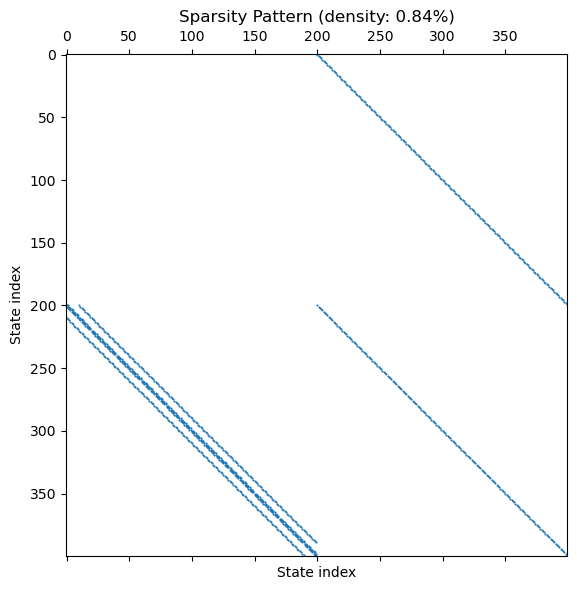

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from getParam_Sonar import getParam_Sonar

Nx, Nz = 20, 10  
Lx, Lz = 100, 50  

p, x_start, t_start, t_stop, max_dt_FE = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)

A = p['A']
B = p['B']
N = Nx * Nz

print(f"System size: {A.shape}")
print(f"Grid: {Nx} x {Nz} = {N} nodes")
print(f"State vector size: {2*N}")
print(f"Source at grid point: ({p['sonar_ix']}, {p['sonar_iz']})")

# Visualize sparsity pattern
fig, ax = plt.subplots(figsize=(6, 6))

ax.spy(A, markersize=0.5)
ax.set_title(f'Sparsity Pattern (density: {np.count_nonzero(A)/A.size:.2%})')
ax.set_xlabel('State index')
ax.set_ylabel('State index')

plt.tight_layout()
plt.show()


# What you see:
#   d[p]/dt = [0   I ][p] + [0]u
#    [v]      [L  -aI][v]   [b]

Next, run provided SimpleSolver. We don't expect stable behavior, since Forward Euler is non-ideal for wave propagation.

In [2]:
from eval_f_Sonar import eval_f_Sonar
from eval_u_Sonar import eval_u_Sonar, eval_u_Sonar_coarse
from SimpleSolver import SimpleSolver

Nx, Nz = 50, 50    # Nx, Nz = 20, 20  
Lx, Lz = 500, 500   # Lx, Lz = 50, 50  

p, x_start, t_start, t_stop, max_dt_FE = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)

eval_u = eval_u_Sonar_coarse # eval_u_Sonar
eval_f = eval_f_Sonar

visualize = False
w = max_dt_FE * 0.1
num_iter = int(np.ceil((t_stop - t_start) / w)) 

print(f"Number of iterations: {num_iter}")

[X, t] = SimpleSolver(eval_f, x_start, p, eval_u, num_iter, w, visualize, gif_file_name="test_SimpleSolver_Sonar.gif")

Number of iterations: 1386
started running a simple solver, please wait...


(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Sonar Simulation Domain Setup'}, xlabel='X Distance (m)', ylabel='Z Depth (m)'>)

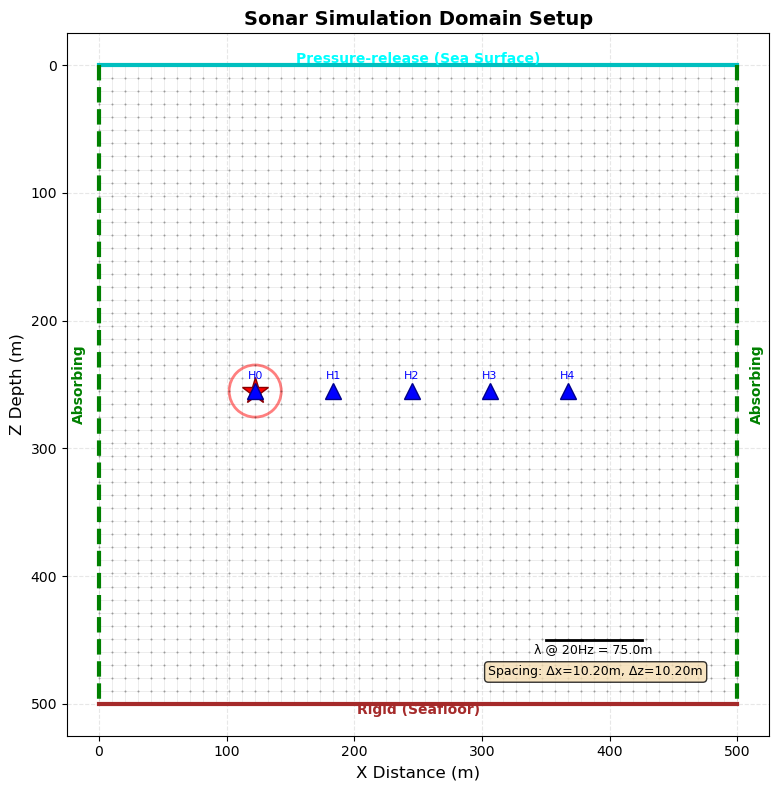

In [3]:
from visualize_sonar import visualize_sonar_setup

visualize_sonar_setup(p, show_grid=True, show_boundary_labels=True)

Processing hydrophone data...


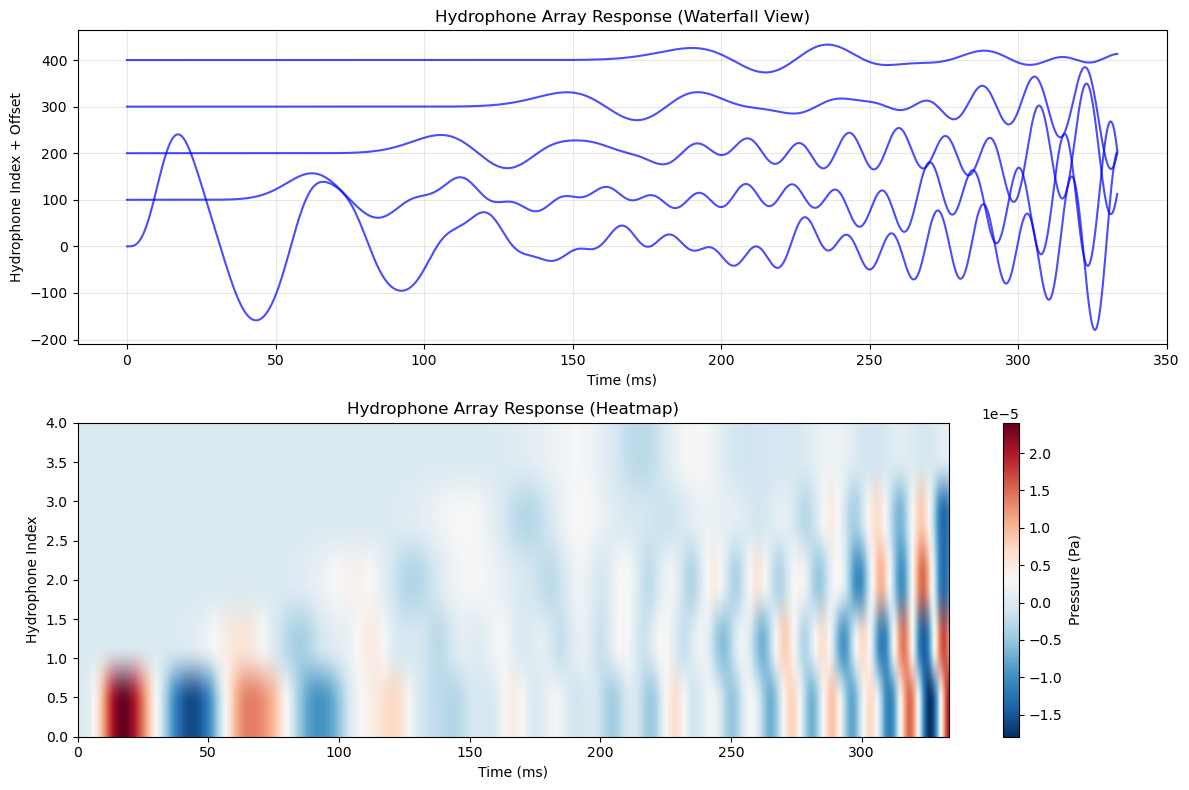

In [4]:
from eval_g_Sonar import eval_g_Sonar

# extract hydrophone outputs over time
print("Processing hydrophone data...")
num_phones = len(p['hydrophones']['x_indices'])
hydrophone_history = np.zeros((num_phones, len(t)))

for i in range(len(t)):
    y = eval_g_Sonar(X[:, i], p)
    hydrophone_history[:, i] = y.flatten()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

adjust_view = 1e7 #1e9

# waterfall plot 
for i in range(num_phones):
    x_pos = p['hydrophones']['x_indices'][i] * p['dx']
    ax1.plot(t*1000, adjust_view*hydrophone_history[i, :] + i*100, 'b-', alpha=0.7)
    
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Hydrophone Index + Offset')
ax1.set_title('Hydrophone Array Response (Waterfall View)')
ax1.grid(True, alpha=0.3)

# heatmap 
im = ax2.imshow(hydrophone_history, aspect='auto', origin='lower',
                extent=[t[0]*1000, t[-1]*1000, 0, num_phones-1],
                cmap='RdBu_r')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Hydrophone Index')
ax2.set_title('Hydrophone Array Response (Heatmap)')
plt.colorbar(im, ax=ax2, label='Pressure (Pa)')

plt.tight_layout()
plt.show()

In [5]:
from simpleLeapFrog import *

X, t = LeapfrogSolver(eval_f, x_start, p, eval_u, num_iter, dt=w, visualize=False)

Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 1385 leapfrog steps...
  Progress: 10.0%
  Progress: 19.9%
  Progress: 29.9%
  Progress: 39.8%
  Progress: 49.8%
  Progress: 59.7%
  Progress: 69.7%
  Progress: 79.7%
  Progress: 89.6%
  Progress: 99.6%
Leapfrog integration complete!


Processing hydrophone data...


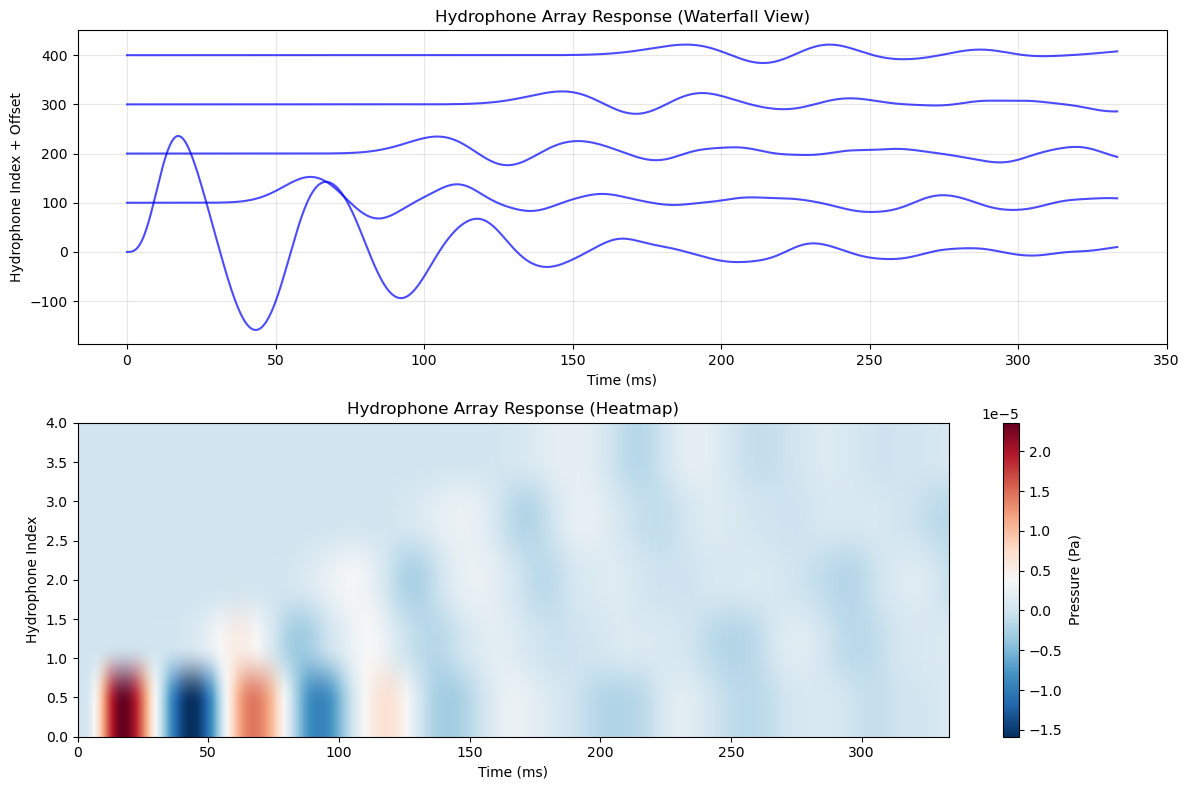

In [6]:
from eval_g_Sonar import eval_g_Sonar

# extract hydrophone outputs over time
print("Processing hydrophone data...")
num_phones = len(p['hydrophones']['x_indices'])
hydrophone_history = np.zeros((num_phones, len(t)))

for i in range(len(t)):
    y = eval_g_Sonar(X[:, i], p)
    hydrophone_history[:, i] = y.flatten()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

adjust_view = 1e7 #1e9

# waterfall plot 
for i in range(num_phones):
    x_pos = p['hydrophones']['x_indices'][i] * p['dx']
    ax1.plot(t*1000, adjust_view*hydrophone_history[i, :] + i*100, 'b-', alpha=0.7)
    
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Hydrophone Index + Offset')
ax1.set_title('Hydrophone Array Response (Waterfall View)')
ax1.grid(True, alpha=0.3)

# heatmap 
im = ax2.imshow(hydrophone_history, aspect='auto', origin='lower',
                extent=[t[0]*1000, t[-1]*1000, 0, num_phones-1],
                cmap='RdBu_r')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Hydrophone Index')
ax2.set_title('Hydrophone Array Response (Heatmap)')
plt.colorbar(im, ax=ax2, label='Pressure (Pa)')

plt.tight_layout()
plt.show()


SOLVER STABILITY COMPARISON

1. Testing SimpleSolver (Forward Euler)...
started running a simple solver, please wait...

2. Testing LeapfrogSolver...
Running Leapfrog solver (stable for wave equations)...
Bootstrapping with first step...
Running 414 leapfrog steps...
  Progress: 9.9%
  Progress: 19.8%
  Progress: 29.6%
  Progress: 39.5%
  Progress: 49.4%
  Progress: 59.3%
  Progress: 69.2%
  Progress: 79.0%
  Progress: 88.9%
  Progress: 98.8%
Leapfrog integration complete!

RESULTS:
Forward Euler - Final energy ratio: 1.49e+36
Leapfrog      - Final energy ratio: 4.31e+01
⚠️  Forward Euler is UNSTABLE (growing energy)


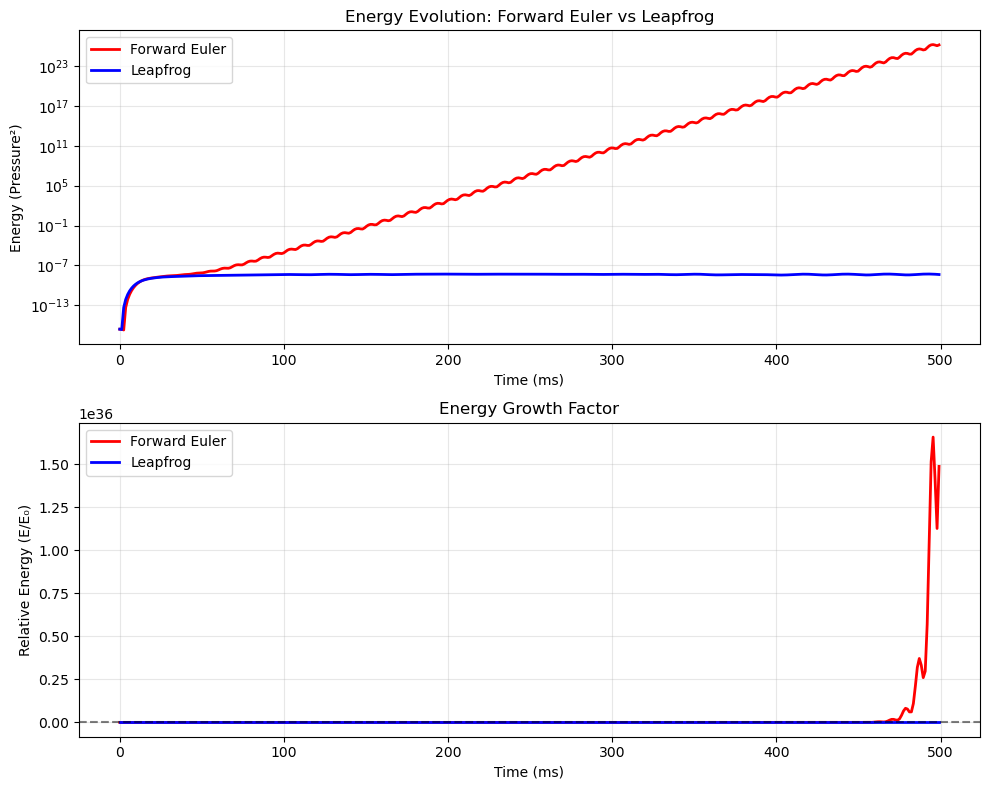

In [7]:
# Compare solvers
fig = test_solver_stability(p, eval_f, eval_u, x_start, max_dt_FE)
plt.show()

Implement our own suite of tests

COMPLETE SONAR MODEL TEST SUITE

PART A: MODEL FUNCTIONALITY TESTS

TEST 1: Matrix Dimensions
----------------------------------------
✓ PASSED: Matrix dimensions correct

TEST 2: Zero Input Response
----------------------------------------
✓ PASSED: Zero state remains stable

TEST 3: Source Excitation
----------------------------------------
✓ PASSED: Source generates signal: 9.51e-01 Pa

TEST 4: CFL Condition
----------------------------------------
✓ PASSED: Timestep 0.001241 respects CFL

TEST 5: Hydrophone Configuration
----------------------------------------
✓ PASSED: 5 hydrophones configured

TEST 6: Short-term Stability
----------------------------------------
started running a simple solver, please wait...
✓ PASSED: No immediate divergence

PART B: JACOBIAN TEST BENCH

TEST 7: Linear System Check
----------------------------------------
✓ PASSED: Jacobian equals A matrix (linear system)

TEST 8: Finite Difference Verification
----------------------------------------
  dx = 1.

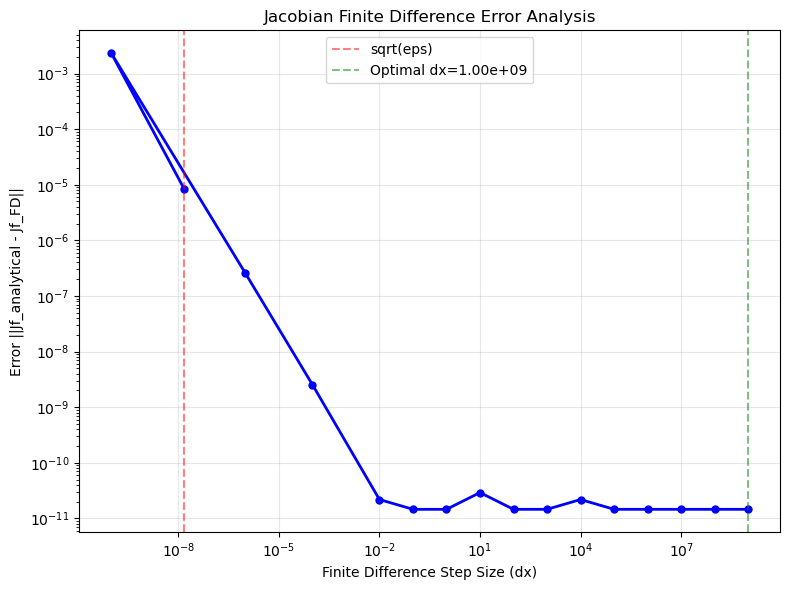


COMPLETE TEST SUMMARY
Total Tests Passed: 10
Total Tests Failed: 0
Overall Success Rate: 100.0%

✓ ALL TESTS PASSED!


(10, 0)

In [8]:
from test_Sonar import test_sonar_complete

test_sonar_complete()

# finite differences Jacobian is sitting right around machine precision
# our system is indeed linear! no truncation error

In [9]:
# Visualize pressure over XZ plane at a given time/index
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

def plot_pressure_xz_at(index=None, time_s=None, cmap='RdBu_r', sym=True, overlay=True):
    """
    Plots the pressure field p(x,z) across the XZ plane at a given time index or time (seconds).
    Requires global variables: p (params dict), X (state over time), t (time vector).
    """
    try:
        Nx, Nz = p['Nx'], p['Nz']
        Lx, Lz = p['Lx'], p['Lz']
        dx, dz = p['dx'], p['dz']
    except Exception as e:
        print('Parameter dict p not found or incomplete:', e)
        return

    N = Nx * Nz
    t_arr = np.asarray(t).reshape(-1)

    # Select frame index by explicit index or nearest time
    if index is None:
        if time_s is None:
            index = len(t_arr) - 1
        else:
            index = int(np.argmin(np.abs(t_arr - float(time_s))))
    index = int(max(0, min(index, X.shape[1] - 1)))

    # Extract pressure field (first Nx*Nz entries of state) and reshape to (Nz, Nx) for plotting
    x_i = np.asarray(X[:, index]).reshape(-1)
    field = x_i[:N].reshape(Nx, Nz).T

    # Symmetric color scale around zero (pressure)
    vmin = vmax = None
    if sym:
        m = float(np.nanmax(np.abs(field))) if field.size else 1.0
        vmin, vmax = -m, m

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    im = ax.imshow(field, extent=[0, Lx, Lz, 0], cmap=cmap, vmin=vmin, vmax=vmax, aspect='equal')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Pressure (Pa)')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    ax.set_title(f'Pressure field on XZ plane at t={t_arr[index]*1000:.3f} ms (idx {index})')

    if overlay:
        try:
            sx = p['sonar_ix'] * dx
            sz = p['sonar_iz'] * dz
            ax.plot([sx], [sz], marker='*', color='yellow', markersize=12, markeredgecolor='k')
            if 'hydrophones' in p and p['hydrophones'].get('n_phones', 0) > 0:
                zpos = p['hydrophones']['z_pos'] * dz
                for x_idx in p['hydrophones']['x_indices']:
                    ax.plot(x_idx * dx, zpos, '^', color='white', markersize=6, markeredgecolor='k', alpha=0.85)
        except Exception:
            pass

    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()
    return fig, ax

# Interactive index slider if ipywidgets is available; fallback to last frame
try:
    import ipywidgets as widgets
    from ipywidgets import widgets as _widgets_alias  # ensure module is loaded
    slider = widgets.IntSlider(value=int(len(np.asarray(t).reshape(-1)) - 1), min=0, max=int(X.shape[1] - 1), step=1, description='Index')
    ui = widgets.HBox([slider])
    out = widgets.interactive_output(lambda Index: plot_pressure_xz_at(index=Index), {'Index': slider})
    display(ui, out)
except Exception as e:
    print('Interactive widgets unavailable; plotting last step. Error:', e)
    plot_pressure_xz_at(index=int(X.shape[1] - 1))


Output()